###  读取数据

In [26]:
import os
import pandas as pd
from matplotlib.font_manager import FontProperties
# 获取macos的中文字体支持库
def getChineseFont():  
    return FontProperties(fname='/System/Library/Fonts/PingFang.ttc',size=15)
excel_names=[excel_name for excel_name in os.listdir("./data")]
df_list=[]

for excel_name in excel_names:
    filename="./data/{}".format(excel_name)
    df=pd.read_csv(filename,sep=",")
    df_list.append(df)
df_merge=pd.concat(df_list)
# df_merge.describe()
# reset index
df_merge.reset_index(inplace=True, drop=True) 
# df_merge.loc[100:200,'买家数':'客单价']
df_merge

,日期,类目名称,买家数,成交金额,搜索人数,成交金额占比,成交金额同比,成交人数占比,成交人数同比,客单价,UV价值
0,2017-10-01|2017-10-31,手机保护套/壳,27524495,503205377,82138973,38.16%,70.34%,52.07%,11.20%,18.28,6.13
1,2017-10-01|2017-10-31,手机贴膜,18384095,190704104,26656100,11.79%,28.26%,25.05%,16.74%,10.37,7.15
2,2017-10-01|2017-10-31,手机零部件,2125787,189281648,15767938,11.72%,12.75%,5.28%,11.70%,89.04,12.00
3,2017-10-01|2017-10-31,移动电源,2801112,188888518,14276910,11.70%,27.56%,7.22%,11.89%,67.43,13.23
4,2017-10-01|2017-10-31,手机数据线,4178627,153248705,10788473,8.04%,68.09%,11.07%,22.33%,36.67,14.20
...,...,...,...,...,...,...,...,...,...,...,...
7845,2020-09-01|2020-09-30,分压盒,1,2425,36,-,1488.67%,-,68.95%,2425.00,67.36
7846,2020-09-01|2020-09-30,白平衡镜,1,1826,56,-,-46.39%,-,11.19%,1826.00,32.61
7847,2020-09-01|2020-09-30,Lomo潜水盒,1,133,22,-,-90.94%,-,-72.61%,133.00,6.05
7848,2020-09-01|2020-09-30,移动支付终端机,0,0,4,-,-99.95%,-,-99.95%,0.00,0.00


#### 数据清洗
##### 分离时间日期

In [27]:
new_date=df_merge['日期'].str.split("|", n = 1, expand = True) 
df_merge['开始日期']=new_date[0]
df_merge['结束日期']=new_date[1]
df_merge['开始日期']=pd.to_datetime(df_merge['开始日期'].astype(str),format='%Y-%m-%d')
df_merge['结束日期']=pd.to_datetime(df_merge['结束日期'].astype(str),format='%Y-%m-%d')
# df_merge.head(10)
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7850 entries, 0 to 7849
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   日期      7850 non-null   object        
 1   类目名称    7850 non-null   object        
 2   买家数     7850 non-null   int64         
 3   成交金额    7850 non-null   int64         
 4   搜索人数    7850 non-null   int64         
 5   成交金额占比  7850 non-null   object        
 6   成交金额同比  7850 non-null   object        
 7   成交人数占比  7850 non-null   object        
 8   成交人数同比  7850 non-null   object        
 9   客单价     7850 non-null   float64       
 10  UV价值    7850 non-null   float64       
 11  开始日期    7850 non-null   datetime64[ns]
 12  结束日期    7850 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(3), object(6)
memory usage: 797.4+ KB


In [28]:
#### 清洗同比和占比

In [29]:
column_list=['成交金额占比','成交金额同比','成交人数占比','成交人数同比']

for column in column_list:
    df_merge[column]=df_merge[column].replace("-","0") 
    df_merge[column]=df_merge[column].str.replace("%","") 
    df_merge[column]=df_merge[column].astype("float64")


1. 计算成交比
2. 计算成交比三个月对均线
3. 计算活跃度
4. 绘制散点图

In [30]:
df_merge.info

<bound method DataFrame.info of                          日期     类目名称       买家数       成交金额      搜索人数  成交金额占比  \
0     2017-10-01|2017-10-31  手机保护套/壳  27524495  503205377  82138973   38.16   
1     2017-10-01|2017-10-31     手机贴膜  18384095  190704104  26656100   11.79   
2     2017-10-01|2017-10-31    手机零部件   2125787  189281648  15767938   11.72   
3     2017-10-01|2017-10-31     移动电源   2801112  188888518  14276910   11.70   
4     2017-10-01|2017-10-31    手机数据线   4178627  153248705  10788473    8.04   
...                     ...      ...       ...        ...       ...     ...   
7845  2020-09-01|2020-09-30      分压盒         1       2425        36    0.00   
7846  2020-09-01|2020-09-30     白平衡镜         1       1826        56    0.00   
7847  2020-09-01|2020-09-30  Lomo潜水盒         1        133        22    0.00   
7848  2020-09-01|2020-09-30  移动支付终端机         0          0         4    0.00   
7849  2020-09-01|2020-09-30     苹果卡贴         0          0         9    0.00   

       成交金额同比  成交人数

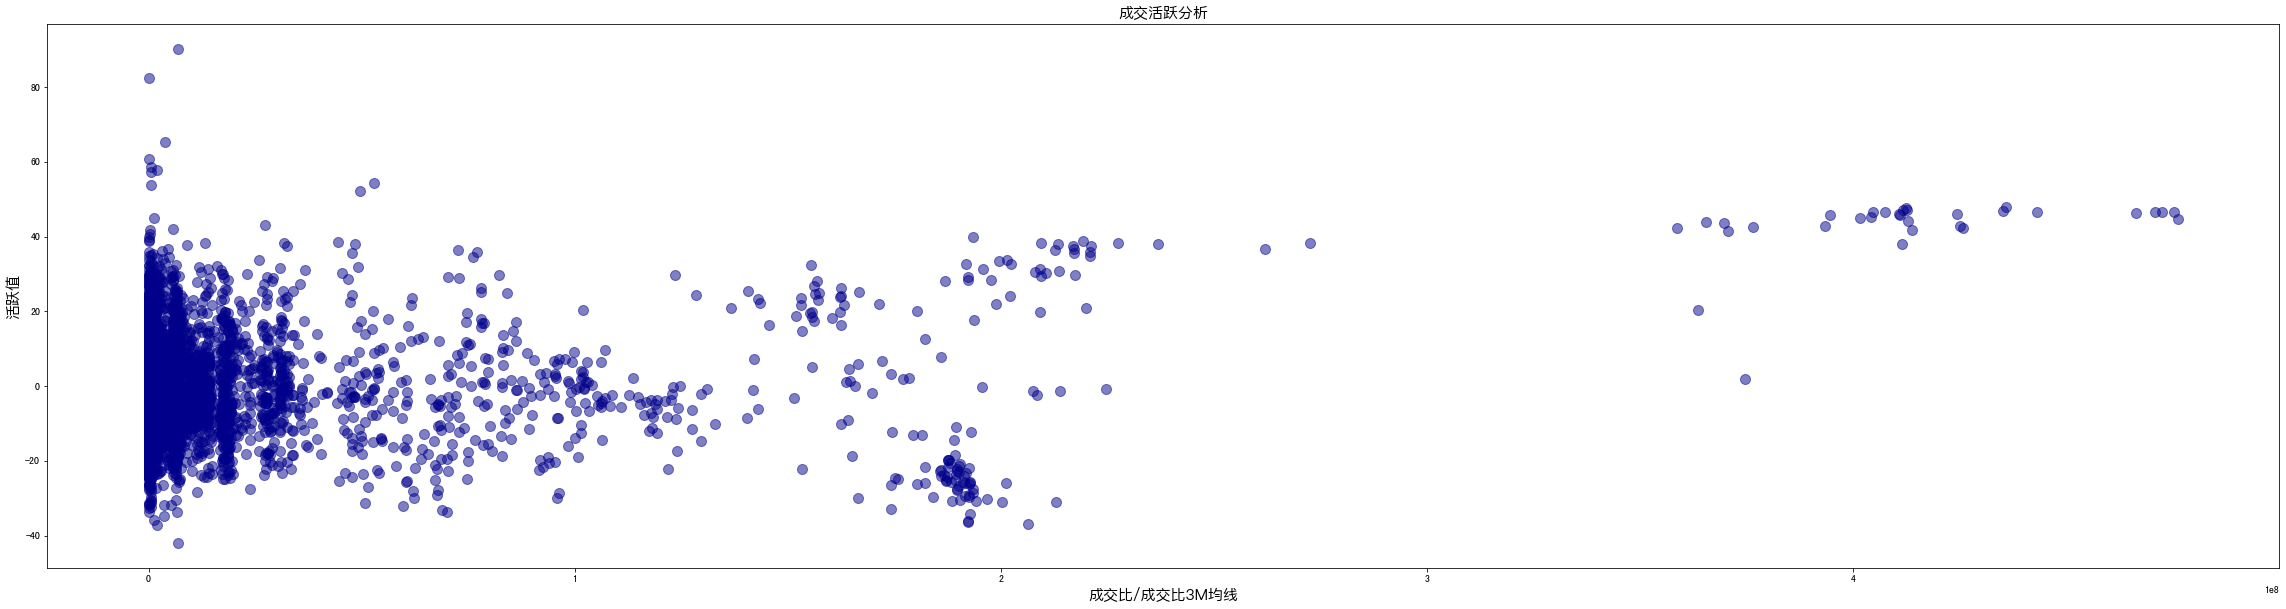

In [33]:
#分析全部数据
import matplotlib.pyplot as plt
%matplotlib inline
all_object=df_merge[:]
#选取一个列作为索引
all_object.set_index(all_object['开始日期'],inplace=True)
# 新列-成交比例
all_object['成交比例'] = all_object['买家数'] / all_object['搜索人数']*100
# 新列-成交比3M均线
all_object['成交比3M均线']=all_object['成交比例'].rolling(3).mean()
# 新列-活跃值 (= 成交比 - 成交比3M均线)
all_object['活跃'] = all_object['成交比例'] - all_object['成交比3M均线']
# bb=all_object['2019-09-01':'2019-09-01'] 
bb=all_object.loc['2019-09-01']
# ax2 = all_object.plot.scatter(x='成交金额',y='活跃',c='DarkBlue',colormap='viridis')
#ax2 = all_object.plot.scatter(x='成交金额',y='活跃',c='DarkBlue',colormap='viridis')



plt.figure(figsize=(40,10))
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
plt.title('成交活跃分析', fontproperties=getChineseFont())
# 索引作为索引
plt.xticks=all_object.index.to_list()
plt.xlabel('成交比/成交比3M均线', fontproperties=getChineseFont())
plt.ylabel('活跃值', fontproperties=getChineseFont())


plt.scatter(all_object['成交金额'],all_object['活跃'], s=100, c='DarkBlue', alpha=0.5)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
df_merge.set_index(df_merge['开始日期'],inplace=True)
# result=df_merge[df_merge["类目名称"]=="手机贴膜"] \
result=df_merge
result['成交比']=result['成交金额']/result['搜索人数']
# result12=result['成交比'].resample('3M').mean()
# result12
result['成交比3M均线']=result['成交比'].rolling(3).mean()
# result['成交比3M均线']=result['成交比3M均线'].interpolate()
# result['成交比3M均线']
# data=result.loc['2018-08':'2019-08',:]
# data
result['活跃'] = result['成交比'] - result['成交比3M均线']

result=result.loc['2020-09-01']
result 
# result.sort_values('活跃',ascending=False)
# result=result.tail(10)
# print(result)
# fig=plt.figure(figsize=(20,5))
# result.plot.figure(figsize=(20,5))
# result.plot.scatter(x='成交金额',y='活跃',c='DarkBlue',colormap='viridis')
result.plot.scatter(x='成交金额',y='活跃',c='DarkBlue',colormap='viridis')
# result

#### 成交比和3m均线图

In [ ]:
item_name="影室灯"

In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline
df_merge.set_index(df_merge['开始日期'],inplace=True)
# result=df_merge[df_merge["类目名称"]=="手机贴膜"] \
result=df_merge[df_merge["类目名称"]==item_name] 

result['成交比']=result['成交金额']/result['搜索人数']
# result12=result['成交比'].resample('3M').mean()
# result12
result['成交比3M均线']=result['成交比'].rolling(5).mean()
fig=plt.figure(figsize=(20,5))
plt.xticks=result.index.to_list()
plt.xlabel('时间')
plt.ylabel('成交比')
lin1=plt.plot(result.index,result['成交比'])
plt.setp(lin1, 'color', 'red', 'linewidth', 1.0)

lin2=plt.plot(result.index,result['成交比3M均线'])
plt.setp(lin2, 'color', 'green', 'linewidth', 3)

# lin3=plt.plot(result13.index,result13)
# plt.setp(lin3, 'color', 'blue', 'linewidth', 3)
plt.show()

#### 使用pyecharts绘制散点图

In [ ]:
result

In [ ]:
result=result.sort_values('成交金额')
result[result['成交金额']==96356856]

In [34]:
from pyecharts.faker import Faker
from pyecharts import options as opts
from pyecharts.charts import Scatter # 导入散点图绘制模块
from pyecharts.globals import ThemeType
# from pyecharts.commons.utils import JsCode
# result=result.sort_values('成交金额')

# # 例1 自定义数据基本示例
# result=result[result['成交金额']>10000000]
result=result.loc['2020-09-01']
# print(result)
scatter = Scatter(init_opts=opts.InitOpts(theme=ThemeType.PURPLE_PASSION))

scatter.add_xaxis(xaxis_data=result['活跃'].to_list())
scatter.add_yaxis(series_name='成交金额散点图'#图例名称
                  ,y_axis=result['成交金额'].to_list()#数据
                  ,label_opts=opts.LabelOpts(is_show=False)#数据不显示
                  ,symbol_size=15#设置散点的大小
                  ,symbol='cricle'#设置散点的形状（cricle,rect,pin,triangle）
                  )
scatter.set_global_opts(
        title_opts=opts.TitleOpts(
            pos_left="10%",
            pos_top="90%",
            title="upper",
            title_textstyle_opts=opts.TextStyleOpts(
                border_color="#999", border_width=1, font_size=14
            ),
        ),
        yaxis_opts=opts.AxisOpts(
            axislabel_opts=opts.LabelOpts(is_show=True),
            axistick_opts=opts.AxisTickOpts(is_show=True),
        ),
    )
# sc.add(
#     "scatter",
#     result['活跃'].to_list(),
#     result['成交金额'].to_list(),
#     extra_data=result['类目名称'].to_list(),)
# scatter =(
#     Scatter()
#     .add_xaxis('活跃',result['活跃'].to_list(),)
#     .add_yaxis('成交金额',result['成交金额'].to_list(),)
#     .set_global_opts(title_opts=opts.TitleOpts(title='例1 scatter自定义数据基本示例'))
# ) 
# scatter1=(
#     Scatter()
#     .add_xaxis('成交金额',result['成交金额'])
#     .add_yaxis('活跃',result['活跃'])
#     .set_global_opts(title_opts=opts.TitleOpts(title='例1 scatter自定义数据基本示例'))
# )
scatter.render_notebook()